In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, auc, roc_curve

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, \
train_model_cross_val, train_model_test, \
get_feature_importance_cv, get_feature_importance, get_feature_importance10

### Load data

In [3]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_20.json")

### Balance data and split to train and test set

In [4]:
label_name = "phase2"

In [5]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [6]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [7]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2),(1,1),(1,3), (2,2),(2,3), (3,3)], # limit to trigrams
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [9]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=5, scoring='f1') #roc_auc

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
done in 6345.555s
Best cross-validation score:  0.9285604375231739
Best parameters set:
	clf__C: 0.1
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	tfidf__use_idf: False


In [8]:
# grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1') #roc_auc

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
done in 5034.406s
Best cross-validation score:  0.9593286580466068
Best parameters set:
	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


##### Model fitting and evaluation

In [11]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=5)

fitting the best model
Accuracy: 0.9299363057324841

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        79
           1       0.95      0.91      0.93        78

    accuracy                           0.93       157
   macro avg       0.93      0.93      0.93       157
weighted avg       0.93      0.93      0.93       157


CR: (0.930650406504065, 0.9298117494320026, 0.9298907968984695, None)

Confusion matrix:
 [[75  4]
 [ 7 71]] 

_______________________


 Accuracy: 92.994 
 Precision: 0.947 
 Recall: 0.910 
 F1: 0.928 
 FPR: 0.051 
 ROC_AUC: 0.930


In [15]:
evaluate(y_train, y_predict_cv)

Accuracy: 0.9299363057324841

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        79
           1       0.95      0.91      0.93        78

    accuracy                           0.93       157
   macro avg       0.93      0.93      0.93       157
weighted avg       0.93      0.93      0.93       157


CR: (0.930650406504065, 0.9298117494320026, 0.9298907968984695, None)

Confusion matrix:
 [[75  4]
 [ 7 71]] 

_______________________


 Accuracy: 92.994 
 Precision: 0.947 
 Recall: 0.910 
 F1: 0.928 
 FPR: 0.051 
 ROC_AUC: 0.930


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [12]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../output/tables/features_svm_cv_full_p2.xlsx', index=True)
df_features_cv.head()

,feature,importance
491,car light,-0.152551
3414,prescription,-0.145527
621,commercial vehicle,-0.142814
1002,currently controlled,-0.132636
2528,italy united,0.129468


In [16]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.9417952314165497

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1406
           1       0.16      0.75      0.27        20

    accuracy                           0.94      1426
   macro avg       0.58      0.85      0.62      1426
weighted avg       0.98      0.94      0.96      1426


CR: (0.5787696924231058, 0.8472617354196301, 0.6175918476803433, None)

Confusion matrix:
 [[1328   78]
 [   5   15]] 

_______________________


 Accuracy: 94.180 
 Precision: 0.161 
 Recall: 0.750 
 F1: 0.265 
 FPR: 0.055 
 ROC_AUC: 0.847


In [19]:
evaluate(y_test, y_predict_cv_test)

Accuracy: 0.9417952314165497

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1406
           1       0.16      0.75      0.27        20

    accuracy                           0.94      1426
   macro avg       0.58      0.85      0.62      1426
weighted avg       0.98      0.94      0.96      1426


CR: (0.5787696924231058, 0.8472617354196301, 0.6175918476803433, None)

Confusion matrix:
 [[1328   78]
 [   5   15]] 

_______________________


 Accuracy: 94.180 
 Precision: 0.161 
 Recall: 0.750 
 F1: 0.265 
 FPR: 0.055 
 ROC_AUC: 0.847


In [20]:
y_predict_cv_test1 = fit_best_model_test(X_test1, y_test1, pipeline_cv)

testing on test set
Accuracy: 0.8

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.83      0.75      0.79        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40


CR: (0.803030303030303, 0.8, 0.7994987468671679, None)

Confusion matrix:
 [[17  3]
 [ 5 15]] 

_______________________


 Accuracy: 80.000 
 Precision: 0.833 
 Recall: 0.750 
 F1: 0.789 
 FPR: 0.150 
 ROC_AUC: 0.800


### Model training (with 10-fold CV) using best parameters from GridSearch

In [21]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 0.1
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	tfidf__use_idf: False


In [22]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (1,2), binary = True, max_df = 0.05, norm = 'l2', use_idf = False))
c = 0.1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [23]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.9044585987261147

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91        79
           1       0.91      0.90      0.90        78

    accuracy                           0.90       157
   macro avg       0.90      0.90      0.90       157
weighted avg       0.90      0.90      0.90       157


CR: (0.9045454545454545, 0.9044141512495942, 0.9044430919050518, None)

Confusion matrix:
 [[72  7]
 [ 8 70]] 

_______________________


 Accuracy: 90.446 
 Precision: 0.909 
 Recall: 0.897 
 F1: 0.903 
 FPR: 0.089 
 ROC_AUC: 0.904


In [24]:
evaluate(y_train, y_predict_train)

Accuracy: 0.9044585987261147

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91        79
           1       0.91      0.90      0.90        78

    accuracy                           0.90       157
   macro avg       0.90      0.90      0.90       157
weighted avg       0.90      0.90      0.90       157


CR: (0.9045454545454545, 0.9044141512495942, 0.9044430919050518, None)

Confusion matrix:
 [[72  7]
 [ 8 70]] 

_______________________


 Accuracy: 90.446 
 Precision: 0.909 
 Recall: 0.897 
 F1: 0.903 
 FPR: 0.089 
 ROC_AUC: 0.904


In [25]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9417952314165497

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1406
           1       0.16      0.75      0.27        20

    accuracy                           0.94      1426
   macro avg       0.58      0.85      0.62      1426
weighted avg       0.98      0.94      0.96      1426


CR: (0.5787696924231058, 0.8472617354196301, 0.6175918476803433, None)

Confusion matrix:
 [[1328   78]
 [   5   15]] 

_______________________


 Accuracy: 94.180 
 Precision: 0.161 
 Recall: 0.750 
 F1: 0.265 
 FPR: 0.055 
 ROC_AUC: 0.847


In [26]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.8

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.83      0.75      0.79        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40


CR: (0.803030303030303, 0.8, 0.7994987468671679, None)

Confusion matrix:
 [[17  3]
 [ 5 15]] 

_______________________


 Accuracy: 80.000 
 Precision: 0.833 
 Recall: 0.750 
 F1: 0.789 
 FPR: 0.150 
 ROC_AUC: 0.800


In [27]:
evaluate(y_test1, y_predict_test1)

Accuracy: 0.8

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.83      0.75      0.79        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40


CR: (0.803030303030303, 0.8, 0.7994987468671679, None)

Confusion matrix:
 [[17  3]
 [ 5 15]] 

_______________________


 Accuracy: 80.000 
 Precision: 0.833 
 Recall: 0.750 
 F1: 0.789 
 FPR: 0.150 
 ROC_AUC: 0.800


### Confusion matrix and model performance

In [28]:
print(df_test_grouped['case_num'].nunique())
print(len(X_test))
print(len(df_test_grouped))

1426
1426
1426


In [29]:
results_test = pd.DataFrame(np.column_stack((X_test, y_test, y_predict_test)), columns=['text', 'target', 'y_predict'])
results_test = pd.concat([df_test_grouped, results_test], axis=1)

In [30]:
tn=results_test[(results_test.target == 0) & (results_test.y_predict == 0)]
fp=results_test[(results_test.target == 0) & (results_test.y_predict == 1)]
fn=results_test[(results_test.target == 1) & (results_test.y_predict == 0)]
tp=results_test[(results_test.target == 1) & (results_test.y_predict == 1)]

print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 1328
FP: 78
FN: 5
TP: 15


In [31]:
fp['article_new'].value_counts()

article6(1)(b)    46
article6(2)       32
Name: article_new, dtype: int64

In [32]:
fp['text']

0       proposed concentration involves acquisition so...
109     competitive landscape transaction need seen li...
134     transaction skf acquire sole control snfa tran...
144     horizontal effect party substantial market sha...
185     market share table party cid share market area...
                              ...                        
1394    analytical framework guideline assessment hori...
1400    identification affected market horizontally af...
1421    analytical framework article merger regulation...
1423    legal framework party concentration actual pot...
1425    salmar nt active market farming primary proces...
Name: text, Length: 78, dtype: object

### Feature importance

In [33]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
491,car light,-0.152551,0.152551
3414,prescription,-0.145528,0.145528
621,commercial vehicle,-0.142814,0.142814
1002,currently controlled,-0.132637,0.132637
2528,italy united,0.129468,0.129468
309,axa,-0.127696,0.127696
40,achieve community,-0.122037,0.122037
1829,fax mail,-0.121363,0.121363
4895,union commission,-0.119138,0.119138
2197,heavy vehicle,-0.117350,0.117350


In [66]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [34]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

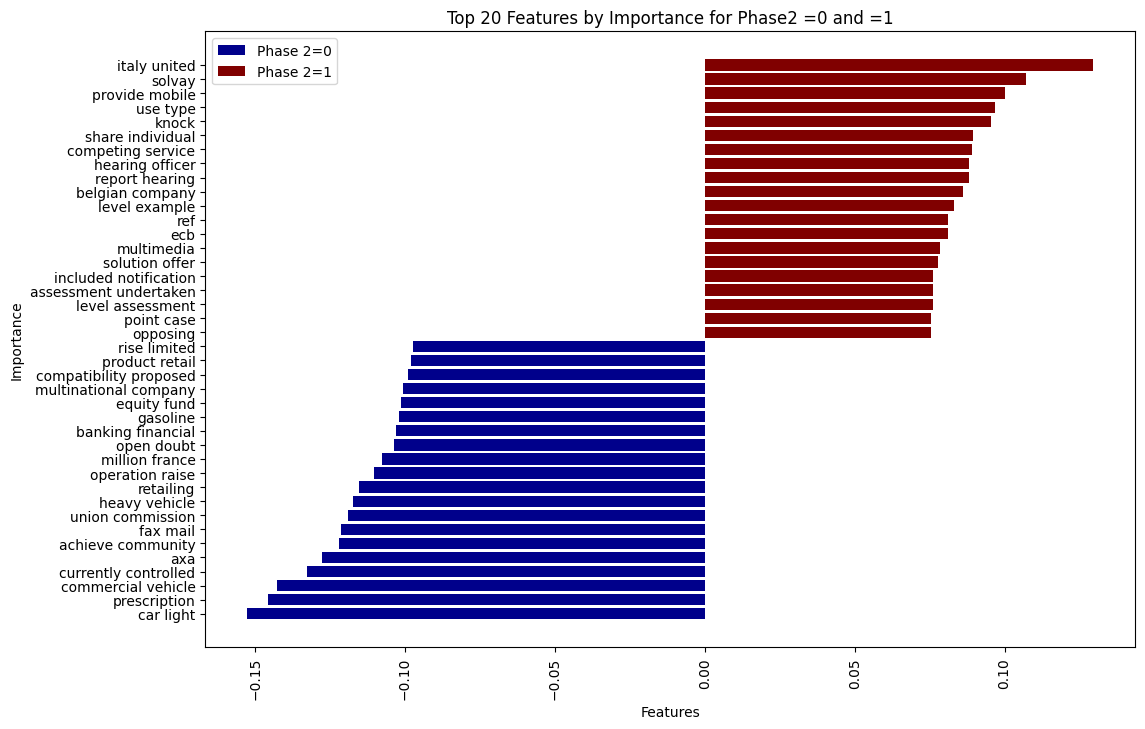

In [35]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Features by Importance for Phase2 =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [36]:
df_features_train.to_excel('../../../output/tables/features_svm_train_full_p2.xlsx', index=True)

In [33]:
y_predict_test1

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [34]:
X_train

0      undertaking concerned combined aggregate world...
1      party overlapping activity area party ’ combin...
2      borden bakelite active production sale amino r...
3      celanese acetex signed arrangement agreement p...
4      interventional cardiology drug eluting stent i...
                             ...                        
152    annex analysis party ’ opportunity data submit...
153    transaction union dimension meaning article me...
154    transaction give rise vertically affected mark...
155    proposed transaction give rise seven horizonta...
156    analytical framework legal test assessment hor...
Name: text_clean, Length: 157, dtype: object